The goal of this notebook is to demonstrate how we estimate the ENL for future notebooks which is related to the speckle noise model.

In [83]:
import rasterio
import numpy
import scipy
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from itertools import starmap
from mpl_toolkits.axes_grid1 import make_axes_locatable


In [5]:
DATA_DIR = Path('data_gulfco/reprojected')
DATA_DIR.exists()

True

In [6]:
hh_paths_original = sorted(list(DATA_DIR.glob('*/*hh*.tif')))
hv_paths_original = sorted(list(DATA_DIR.glob('*/*hv*.tif')))
vv_paths_original = sorted(list(DATA_DIR.glob('*/*vv*.tif')))
hv_paths_original

[PosixPath('data_gulfco/reprojected/hv/UAVSAR_RTC_hv_20190620.tif'),
 PosixPath('data_gulfco/reprojected/hv/UAVSAR_RTC_hv_20190701.tif'),
 PosixPath('data_gulfco/reprojected/hv/UAVSAR_RTC_hv_20190716.tif'),
 PosixPath('data_gulfco/reprojected/hv/UAVSAR_RTC_hv_20190725.tif'),
 PosixPath('data_gulfco/reprojected/hv/UAVSAR_RTC_hv_20190812.tif'),
 PosixPath('data_gulfco/reprojected/hv/UAVSAR_RTC_hv_20190923.tif'),
 PosixPath('data_gulfco/reprojected/hv/UAVSAR_RTC_hv_20190930.tif')]

In [61]:
LAMBDA_M = 2.0

In [63]:
MIDAL_DIR = Path(f'out/midal/{LAMBDA_M:1.2f}')
MIDAL_DIR.exists()

True

In [92]:
hh_paths_midal = sorted(list(MIDAL_DIR.glob('*hh/*.tif')))
hv_paths_midal = sorted(list(MIDAL_DIR.glob('*hv/*.tif')))
vv_paths_midal = sorted(list(MIDAL_DIR.glob('*vv/*vv*.tif')))

hv_paths_midal

[PosixPath('out/midal/2.00/hv/UAVSAR_RTC_hv_20190620_midal_lamb=2.00.tif'),
 PosixPath('out/midal/2.00/hv/UAVSAR_RTC_hv_20190701_midal_lamb=2.00.tif'),
 PosixPath('out/midal/2.00/hv/UAVSAR_RTC_hv_20190716_midal_lamb=2.00.tif'),
 PosixPath('out/midal/2.00/hv/UAVSAR_RTC_hv_20190725_midal_lamb=2.00.tif'),
 PosixPath('out/midal/2.00/hv/UAVSAR_RTC_hv_20190812_midal_lamb=2.00.tif'),
 PosixPath('out/midal/2.00/hv/UAVSAR_RTC_hv_20190923_midal_lamb=2.00.tif'),
 PosixPath('out/midal/2.00/hv/UAVSAR_RTC_hv_20190930_midal_lamb=2.00.tif')]

In [93]:
LAMBDA_R = 2.0

In [94]:
RABASAR_PATH_NAME = f'out/rabasar/final/lamb={LAMBDA_R:1.2f}/'
RABASAR_PATH = Path(RABASAR_PATH_NAME)
hh_paths_rabasar = sorted(list(RABASAR_PATH.glob('*/*hh*.tif')))
hv_paths_rabasar = sorted(list(RABASAR_PATH.glob('*/*hv*.tif')))
vv_paths_rabasar = sorted(list(RABASAR_PATH.glob('*/*vv*.tif')))

vv_paths_rabasar

[PosixPath('out/rabasar/final/lamb=2.00/vv/UAVSAR_RTC_vv_20190620_rabarsar_lamb=2.00.tif'),
 PosixPath('out/rabasar/final/lamb=2.00/vv/UAVSAR_RTC_vv_20190701_rabarsar_lamb=2.00.tif'),
 PosixPath('out/rabasar/final/lamb=2.00/vv/UAVSAR_RTC_vv_20190716_rabarsar_lamb=2.00.tif'),
 PosixPath('out/rabasar/final/lamb=2.00/vv/UAVSAR_RTC_vv_20190725_rabarsar_lamb=2.00.tif'),
 PosixPath('out/rabasar/final/lamb=2.00/vv/UAVSAR_RTC_vv_20190812_rabarsar_lamb=2.00.tif'),
 PosixPath('out/rabasar/final/lamb=2.00/vv/UAVSAR_RTC_vv_20190923_rabarsar_lamb=2.00.tif'),
 PosixPath('out/rabasar/final/lamb=2.00/vv/UAVSAR_RTC_vv_20190930_rabarsar_lamb=2.00.tif')]

In [95]:
def read_arr(path):
    with rasterio.open(path) as ds:
        arr = (ds.read(1))
    return arr

In [96]:
hv_ts = list(map(read_arr, tqdm(hv_paths_original)))
hh_ts = list(map(read_arr, tqdm(hh_paths_original)))
vv_ts = list(map(read_arr, tqdm(vv_paths_original)))

100%|██████████| 7/7 [00:00<00:00,  7.44it/s]


In [97]:
hv_ts_rabasar = list(map(read_arr, tqdm(hv_paths_rabasar)))
hh_ts_rabasar = list(map(read_arr, tqdm(hh_paths_rabasar)))
vv_ts_rabasar = list(map(read_arr, tqdm(vv_paths_rabasar)))

100%|██████████| 7/7 [00:01<00:00,  5.94it/s]


In [98]:
hv_ts_midal = list(map(read_arr, tqdm(hv_paths_midal)))
hh_ts_midal = list(map(read_arr, tqdm(hh_paths_midal)))
vv_ts_midal = list(map(read_arr, tqdm(vv_paths_midal)))

100%|██████████| 7/7 [00:01<00:00,  4.65it/s]
0it [00:00, ?it/s]


In [177]:
TS_INDEX = 0
SLICE_INDEX = 1

In [178]:
# Zoom Out East of Atchafalaya
if SLICE_INDEX == 0:
    sy = np.s_[1_000:2_000]
    sx = np.s_[5_000:6_000]
# Zoom In East of Atchafalaya
if SLICE_INDEX == 1:
    sy = np.s_[1_200:1_600]
    sx = np.s_[5_200:5_600]

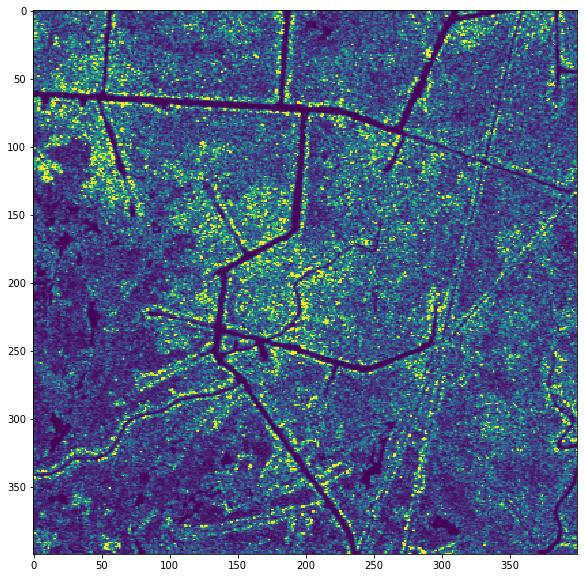

In [179]:
X = hh_ts[TS_INDEX][sy, sx]
plt.figure(figsize=(10, 10))
plt.imshow(X, vmin=0, vmax=1)

In [180]:
PLOT_DIR_NAME = f'plots/'
PLOT_DIR = Path(PLOT_DIR_NAME)
PLOT_DIR.mkdir(exist_ok=True, parents=True)

In [181]:
def plot(img, dest_path, title='', sy=np.s_[:], sx=np.s_[:], vmin=None, vmax=None, title_fs=20):
    fig, ax = plt.subplots(figsize=(9, 9))
    
    im = ax.imshow(img[sy, sx], vmin=vmin, vmax=vmax)
    divider = make_axes_locatable(ax)
    ax.set_title(title, fontsize=title_fs)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(im, cax=cax)
    plt.savefig(dest_path)
    plt.close('all')
    return dest_path

In [182]:
def make_gif(dest_paths, out_gif_path):
    N = len(dest_paths)
    with Image() as wand:
        for k in range(N):
            with Image(filename=dest_paths[k]) as one:
                wand.sequence.append(one)

        for cursor in range(N):
            with wand.sequence[cursor] as frame:
                frame.delay = 120# * (cursor + 1)

        # Set layer type
        wand.type = 'optimize'
        wand.save(filename=out_gif_path)
    return out_gif_path

# Original

In [183]:
len('UAVSAR_RTC_hh_20190620')

22

In [184]:
hh_paths[0].name

'UAVSAR_RTC_hh_20190620.tif'

In [188]:
ORIGINAL_PLOT_DIR = PLOT_DIR/f'original'
ORIGINAL_PLOT_DIR.mkdir(exist_ok=True, parents=True)

n = len(hv_paths_midal)
for time_series, paths, pol in zip([hh_ts, hv_ts],
                                   [hh_paths_original, hv_paths_original],
                                   ['hh', 'hv']):
    dest_dir = ORIGINAL_PLOT_DIR/pol/f'slice_index={SLICE_INDEX}'
    dest_dir.mkdir(exist_ok=True, parents=True)
    
    #dest_paths = [dest_dir/path.name[:22] for path in paths]
    dest_paths = [dest_dir/f'p-{k}' for k in range(n)]

    
    if pol == 'hv':
        vmax=.2
    else:
        vmax=.9
        
    plot_partial = lambda img, dest_path, title: plot(img, dest_path, title=title,
                                           vmin=0, vmax=vmax, 
                                           sy=sy, sx=sx)
    titles = list(map(lambda x: x.name, paths))
    list(starmap(plot_partial, zip(tqdm(time_series), dest_paths, titles)))

100%|██████████| 7/7 [00:01<00:00,  5.79it/s]


# Midal

In [189]:
MIDAL_PLOT_DIR = PLOT_DIR/f'midal_{LAMBDA_M:1.2f}'
MIDAL_PLOT_DIR.mkdir(exist_ok=True, parents=True)

n = len(hv_paths_midal)
for time_series, paths, pol in zip([hh_ts_midal, hv_ts_midal],
                                   [hh_paths_midal, hv_paths_midal],
                                   ['hh', 'hv']):
    dest_dir = MIDAL_PLOT_DIR/pol/f'slice_index={SLICE_INDEX}'
    dest_dir.mkdir(exist_ok=True, parents=True)
    
    #dest_paths = [dest_dir/path.name[:22] for path in paths]
    dest_paths = [dest_dir/f'p-{k}' for k in range(n)]

    
    if pol == 'hv':
        vmax=.2
    else:
        vmax=.9
        
    plot_partial = lambda img, dest_path, title: plot(img, dest_path, title=title,
                                           vmin=0, vmax=vmax, 
                                           sy=sy, sx=sx)
    titles = list(map(lambda x: x.name, paths))
    list(starmap(plot_partial, zip(tqdm(time_series), dest_paths, titles)))

100%|██████████| 7/7 [00:01<00:00,  4.73it/s]


# Rabasar

In [190]:
RABASAR_PLOT_DIR = PLOT_DIR/f'rabasar_{LAMBDA_R:1.2f}'
RABASAR_PLOT_DIR.mkdir(exist_ok=True, parents=True)

n = len(hv_paths_midal)
for time_series, paths, pol in zip([hh_ts_rabasar, hv_ts_rabasar],
                                   [hh_paths_rabasar, hv_paths_rabasar],
                                   ['hh', 'hv']):
    dest_dir = RABASAR_PLOT_DIR/pol/f'slice_index={SLICE_INDEX}'
    dest_dir.mkdir(exist_ok=True, parents=True)
    
    #dest_paths = [dest_dir/path.name[:22] for path in paths]
    dest_paths = [dest_dir/f'p-{k}' for k in range(n)]

    if pol == 'hv':
        vmax=.2
    else:
        vmax=.9
        
    plot_partial = lambda img, dest_path, title: plot(img, dest_path, title=title,
                                           vmin=0, vmax=vmax, 
                                           sy=sy, sx=sx)
    titles = list(map(lambda x: x.name, paths))
    list(starmap(plot_partial, zip(tqdm(time_series), dest_paths, titles)))

100%|██████████| 7/7 [00:01<00:00,  5.35it/s]
